## Quick look at a ResStock run, and extract to individual building load shapes

Run on Windows side to access google drive.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, re
#%matplotlib ipympl

In [125]:
year=2012
if year==2012:
    datadir = "2012 AMY (December 28)\EEDR Results 2020-12-21(8784 hours)"
    data_file = 'Baseline for Upgrade01_8784_hours.csv'
else:
    datadir = "ResStock_update_20200617"
    data_file = 'lbnl_geb_support_revamp4.csv'
indir = r"G:\\Shared drives\BTO Topic 2  Integrating EE & DR\Task 2\Load_Shape_Data\ResStock\{d}".format(d=datadir)


In [92]:
summ = pd.read_parquet(os.path.join(indir,'results_up00.parquet'))
#summ = pd.read_csv(os.path.join(indir, 'results_up00.csv'))

OSError: Passed non-file path: G:\\Shared drives\BTO Topic 2  Integrating EE & DR\Task 2\Load_Shape_Data\ResStock\2012 AMY (December 28)\EEDR Results 2020-12-21(missing hours)\results_up00.parquet

In [93]:
summ.head()

building_id  job_id          started_at        completed_at  \
0           14     322 2020-12-18 12:45:31 2020-12-18 12:46:27   
1           15     635 2020-12-18 15:02:39 2020-12-18 15:05:00   
2           20     202 2020-12-18 12:12:40 2020-12-18 12:15:25   
3           23      50 2020-12-18 07:14:56 2020-12-18 07:23:05   
4           24     503 2020-12-18 13:30:44 2020-12-18 13:32:35   

  completed_status apply_upgrade.applicable apply_upgrade.upgrade_name  \
0          Success                     None                       None   
1          Success                     None                       None   
2          Success                     None                       None   
3          Success                     None                       None   
4          Success                     None                       None   

  apply_upgrade.reference_scenario build_existing_model.applicable  \
0                                                             True   
1                                                             True   
2                                                             True   
3                                                             True   
4                                                             True   

  build_existing_model.bathroom_spot_vent_hour  ...  \
0                                       Hour14  ...   
1                                        Hour7  ...   
2                                        Hour3  ...   
3                                        Hour3  ...   
4                                       Hour10  ...   

  simulation_output_report.total_site_fuel_oil_mbtu  \
0                                         48.605878   
1                                          0.000000   
2                                          0.000000   
3                                          0.000000   
4                                          0.000000   

  simulation_output_report.total_site_natural_gas_therm  \
0                                           0.000000      
1                                         130.391741      
2                                         479.057218      
3                                           0.000000      
4                                        2486.601604      

  simulation_output_report.total_site_propane_mbtu  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   

  simulation_output_report.total_site_wood_mbtu  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

  simulation_output_report.upgrade_cost_usd  \
0                                             
1                                             
2                                             
3                                             
4                                             

  simulation_output_report.wall_area_above_grade_conditioned_ft_2  \
0                                            1198.39                
1                                            2275.72                
2                                            1493.33                
3                                            3520.00                
4                                            4922.18                

  simulation_output_report.wall_area_above_grade_exterior_ft_2  \
0                                            1641.28             
1                                            2658.82             
2                                            1653.33             
3                                            3840.00             
4                                            5237.18           

In [94]:
len(summ)

137047

In [95]:
summ.columns.values[summ.columns.str.contains('water')]

array(['build_existing_model.hot_water_distribution',
       'build_existing_model.hot_water_fixtures',
       'build_existing_model.solar_hot_water',
       'build_existing_model.water_heater',
       'build_existing_model.water_heater_dr',
       'simulation_output_report.electricity_water_systems_kwh',
       'simulation_output_report.fuel_oil_water_systems_mbtu',
       'simulation_output_report.natural_gas_water_systems_therm',
       'simulation_output_report.propane_water_systems_mbtu',
       'simulation_output_report.size_water_heater_gal'], dtype=object)

In [96]:
summ['build_existing_model.water_heater'].value_counts()

Gas Standard          79039
Electric Standard     40571
Oil Standard           5954
Propane Standard       4944
FIXME Oil Indirect     3419
Gas Tankless           1996
Electric Tankless       592
FIXME Other Fuel        316
Propane Tankless        170
Name: build_existing_model.water_heater, dtype: int64

In [10]:
sel=summ['build_existing_model.geometry_building_type_recs'].str.contains('Attached').fillna(False)


In [11]:
summ.loc[sel, ['building_id',
               'build_existing_model.geometry_house_size',
    'build_existing_model.geometry_building_type_recs',
       'simulation_output_report.total_site_electricity_kwh',
       'build_existing_model.units_modeled',
       'build_existing_model.units_represented',
      'simulation_output_report.floor_area_conditioned_ft_2',
       'build_existing_model.hvac_system_heating_electricity',
               'build_existing_model.hvac_system_is_heat_pump',
               'build_existing_model.hvac_system_cooling_type',
      #'build_existing_model.bedrooms',
   ]].round()['build_existing_model.hvac_system_cooling_type'].unique()

array(['None', 'Room', 'Central'], dtype=object)

In [12]:
brief_summ = summ.groupby([
    'build_existing_model.location_weather_filename',
    'build_existing_model.geometry_building_type_recs',
    'build_existing_model.geometry_house_size',
    ]).agg({'building_id':'count',
            'build_existing_model.units_represented':'sum', 
            'build_existing_model.hvac_system_cooling_type':lambda x: ((x!='None')&(~x.isna())).sum(),
            'build_existing_model.hvac_system_heating_electricity':lambda x: ((x!='None')&(~x.isna())).sum(),
            'build_existing_model.hvac_system_is_heat_pump':lambda x: (x!='No').sum(),
            'build_existing_model.dishwasher':lambda x: ((x!='None')&(~x.isna())).sum(),
            'build_existing_model.clothes_washer_presence':lambda x: ((x!='None')&(~x.isna())).sum(),
            'build_existing_model.clothes_dryer':lambda x: x.str.contains('Electric').sum(),
            'build_existing_model.cooking_range':lambda x: x.str.contains('Electric').sum(),
            'build_existing_model.water_heater':lambda x: x.str.contains('Electric').sum(),
            'build_existing_model.misc_pool_pump':lambda x: ((x!='None')&(~x.isna())).sum(),
            'simulation_output_report.floor_area_conditioned_ft_2':'sum',
            #'simulation_output_report.wall_area_above_grade_exterior_ft_2':'sum',
            'build_existing_model.bedrooms':lambda x: x.values.astype(int).mean()
           }
          ).reset_index().rename(
            columns={'building_id':'num_buildings', 
                     'build_existing_model.location_weather_filename':'weather_station',
                     'build_existing_model.geometry_building_type_recs':'building_type',
                     'build_existing_model.geometry_house_size':'size',
                     'build_existing_model.units_represented': 'num_units',
                     'build_existing_model.hvac_system_cooling_type': 'num_with_ac',
                     'build_existing_model.hvac_system_heating_electricity': 'num_with_er_heat',
                     'build_existing_model.hvac_system_is_heat_pump': 'num_with_hp',
                     'build_existing_model.dishwasher':'num_with_dishwasher',
                     'build_existing_model.clothes_washer_presence':'num_with_clothes_washer',
                     'build_existing_model.clothes_dryer':'num_with_elec_clothes_dryer',
                     'build_existing_model.cooking_range':'num_with_elec_cooking',
                     'build_existing_model.water_heater':'num_with_elec_water_heater',
                     'build_existing_model.misc_pool_pump':'num_with_pool_pump',
                     #'simulation_output_report.wall_area_above_grade_exterior_ft_2': 'tot_ft_2',
                     'simulation_output_report.floor_area_conditioned_ft_2':'tot_cond_ft_2',
                     'build_existing_model.bedrooms':'mean_num_bedrooms'})

brief_summ[brief_summ['building_type'].str.contains('Detached')]

weather_station           building_type  \
14                   USA_CA_Arcata.AP.725945.epw  Single-Family Detached   
15                   USA_CA_Arcata.AP.725945.epw  Single-Family Detached   
16                   USA_CA_Arcata.AP.725945.epw  Single-Family Detached   
17                   USA_CA_Arcata.AP.725945.epw  Single-Family Detached   
34   USA_CA_Bakersfield-Meadows.Field.723840.epw  Single-Family Detached   
..                                           ...                     ...   
693      USA_TX_Wichita.Falls.Muni.AP.723510.epw  Single-Family Detached   
710         USA_VT_Burlington.Intl.AP.726170.epw  Single-Family Detached   
711         USA_VT_Burlington.Intl.AP.726170.epw  Single-Family Detached   
712         USA_VT_Burlington.Intl.AP.726170.epw  Single-Family Detached   
713         USA_VT_Burlington.Intl.AP.726170.epw  Single-Family Detached   

          size  num_buildings  num_units  num_with_ac  num_with_er_heat  \
14      0-1499            188      188.0          117                31   
15   1500-2499            222      222.0          150                37   
16   2500-3499             83       83.0           55                24   
17       3500+             47       47.0           31                10   
34      0-1499            280      280.0          165                47   
..         ...            ...        ...          ...               ...   
693      3500+             46       46.0           45                15   
710     0-1499            236      236.0          152                11   
711  1500-2499            362      362.0          248                12   
712  2500-3499            169      169.0          111                 8   
713      3500+            104      104.0           70                 3   

     num_with_hp  num_with_dishwasher  num_with_clothes_washer  \
14             9                  188                      188   
15             7                  222                      222   
16             3                   83                       83   
17             1                   47                       47   
34            13                  280                      280   
..           ...                  ...                      ...   
693            4                   46                       46   
710            0                  236                      236   
711            1                  362                      362   
712            0                  169                      169   
713            1                  104                      104   

     num_with_elec_clothes_dryer  num_with_elec_cooking  \
14                            84                     61   
15                            95                     78   
16                            50                     35   
17                            29                     16   
34                           102                     82   
..                           ...                    ...   
693                           37                     25   
710                          206                    159   
711                          317                    238   
712                          148                    119   
713                           90                     67   

     num_with_elec_water_heater  num_with_pool_pump  tot_cond_ft_2  \
14                           36                  26       188000.0   
15                           28                  33       444000.0   
16                           15                  11       249000.0   
17                            9                   4       211500.0   
34                           24                  41       280000.0   
..                          ...                 ...            ...   
693                          25                   3       207000.0   
710                          68                  37       236000.0   
711                         100                  39       724000.0   
712              

In [13]:

brief_summ.to_csv(os.path.join(indir,'brief_summary.csv'), index=False)

In [126]:

#Handling for different file formats between 2012 and 2016 data
if year==2012:
    ic=False
else:
    ic=0
    
data1 = pd.read_csv(os.path.join(indir, data_file), nrows=8784, header=0, index_col=ic
                   ).reset_index(drop=True)
data2 = pd.read_csv(os.path.join(indir, data_file), nrows=8784, 
                    skiprows=range(1,8785), header=0, index_col=ic).reset_index(drop=True)

In [127]:
data1.columns

Index(['location', 'unit_type', 'time', 'Baseline_Building_Electricity',
       'Baseline_Heating', 'Baseline_Central_System_Heating',
       'Baseline_Cooling', 'Baseline_Central_System_Cooling',
       'Baseline_Water_Heating', 'Baseline_Interior_Lights',
       'Baseline_Exterior_Lights', 'Baseline_Interior_Equipment',
       'Baseline_Heating_Fans', 'Baseline_Cooling_Fans',
       'Baseline_Heating_Pumps', 'Baseline_Cooling_Pumps',
       'Baseline_Central_System_Heating_Pumps',
       'Baseline_Central_System_Cooling_Pumps', 'Baseline_Clothes_Washer',
       'Baseline_Clothes_Dryer_Electric', 'Baseline_Dishwasher',
       'Baseline_Refrigerator', 'Baseline_Cooking_Range',
       'Baseline_Extra_Refrigerator', 'Baseline_Freezer',
       'Baseline_Plug_Loads', 'Baseline_House_Fan', 'Baseline_Range_Fan',
       'Baseline_Bath_Fan', 'Baseline_Ceiling_Fan',
       'Baseline_Hot_Tub_Heater_Electric', 'Baseline_Hot_Tub_Pump',
       'Baseline_Pool_Heater_Electric', 'Baseline_Pool_Pump',


In [128]:
#Remove "Baseline" designation that showed up in 2012 data, if present


def remove_baseline_headers(data):
    rename_cols={}
    
    for c in data.columns.values:
        if re.match('^Baseline_',c):
            rename_cols[c] = c[9:]
        
    return data.rename(columns=rename_cols)
    

data1 = remove_baseline_headers(data1)
data2 = remove_baseline_headers(data2)
data1.head()
    

location    unit_type                     time  \
0  CA_Arcata.AP.725945  Mobile Home  2012-01-01 01:00:00.000   
1  CA_Arcata.AP.725945  Mobile Home  2012-01-01 02:00:00.000   
2  CA_Arcata.AP.725945  Mobile Home  2012-01-01 03:00:00.000   
3  CA_Arcata.AP.725945  Mobile Home  2012-01-01 04:00:00.000   
4  CA_Arcata.AP.725945  Mobile Home  2012-01-01 05:00:00.000   

   Building_Electricity   Heating  Central_System_Heating   Cooling  \
0              1.226554  0.610843                     0.0  0.000099   
1              1.095393  0.524394                     0.0  0.000000   
2              1.142317  0.605906                     0.0  0.000000   
3              1.145140  0.626035                     0.0  0.000000   
4              1.200023  0.674099                     0.0  0.000000   

   Central_System_Cooling  Water_Heating  Interior_Lights  ...  House_Fan  \
0                     0.0       0.007780         0.052357  ...        0.0   
1                     0.0       0.017255         0.031414  ...        0.0   
2                     0.0       0.014181         0.020943  ...        0.0   
3                     0.0       0.018343         0.020943  ...        0.0   
4                     0.0       0.033805         0.023284  ...        0.0   

   Range_Fan  Bath_Fan  Ceiling_Fan  Hot_Tub_Heater_Electric  Hot_Tub_Pump  \
0   0.000108  0.000941     0.019565                 0.004789      0.004728   
1   0.000538  0.001600     0.018098                 0.005787      0.005713   
2   0.000645  0.001506     0.018098                 0.004789      0.004728   
3   0.000108  0.001250     0.017608                 0.005787      0.005713   
4   0.000000  0.002016     0.016141                 0.009379      0.009258   

   Pool_Heater_Electric  Pool_Pump  Well_Pump  Garage_Lighting  
0                   0.0        0.0   0.006643              0.0  
1                   0.0        0.0   0.003472              0.0  
2                   0.0        0.0   0.002869              0.0  
3                   0.0        0.0   0.002265              0.0  
4                   0.0        0.0   0.002416              0.0  

[5 rows x 36 columns]

In [129]:

eu_cols = ['Heating', 'Central_System_Heating', 'Cooling',
       'Central_System_Cooling', 'Water_Heating', 'Interior_Lights',
       'Exterior_Lights', #'Interior_Equipment', 
       'Heating_Fans', 'Cooling_Fans',
       #'Heating_Fans.1', 
       'Cooling_Pumps', 'Central_System_Heating_Pumps',
       'Central_System_Cooling_Pumps', 'Clothes_Washer',
       'Clothes_Dryer_Electric', 'Dishwasher', 'Refrigerator', 'Cooking_Range',
       'Extra_Refrigerator', 'Freezer', 'Plug_Loads', 'House_Fan', 'Range_Fan',
       'Bath_Fan', 'Ceiling_Fan', 'Hot_Tub_Heater_Electric', 'Hot_Tub_Pump',
       'Pool_Heater_Electric', 'Pool_Pump', 'Well_Pump', 'Garage_Lighting',]
       #'Holiday_Lights'])

#Deal with EU names that are inconsistently present in ResStock runs
if 'Holiday_Lights' in data1.columns.values:
    eu_cols += ['Holiday_Lights',]
    
if 'Heating_Pumps' in data1.columns.values:
    eu_cols += ['Heating_Pumps',]
    
eu_cols=np.array(eu_cols)

In [130]:
data1.tail()

location    unit_type                     time  \
8779  CA_Arcata.AP.725945  Mobile Home  2012-12-31 20:00:00.000   
8780  CA_Arcata.AP.725945  Mobile Home  2012-12-31 21:00:00.000   
8781  CA_Arcata.AP.725945  Mobile Home  2012-12-31 22:00:00.000   
8782  CA_Arcata.AP.725945  Mobile Home  2012-12-31 23:00:00.000   
8783  CA_Arcata.AP.725945  Mobile Home  2013-01-01 00:00:00.000   

      Building_Electricity   Heating  Central_System_Heating   Cooling  \
8779              2.347192  0.742372                     0.0  0.000000   
8780              2.370683  0.884472                     0.0  0.000904   
8781              2.294672  0.949489                     0.0  0.001872   
8782              1.760802  0.597099                     0.0  0.000211   
8783              1.629445  0.746920                     0.0  0.000000   

      Central_System_Cooling  Water_Heating  Interior_Lights  ...  House_Fan  \
8779                     0.0       0.143665         0.408791  ...        0.0   
8780                     0.0       0.158711         0.331003  ...        0.0   
8781                     0.0       0.139084         0.248749  ...        0.0   
8782                     0.0       0.138292         0.216061  ...        0.0   
8783                     0.0       0.095933         0.105442  ...        0.0   

      Range_Fan  Bath_Fan  Ceiling_Fan  Hot_Tub_Heater_Electric  Hot_Tub_Pump  \
8779   0.000484  0.002110     0.032771                 0.012173      0.012016   
8780   0.000591  0.002070     0.034728                 0.010177      0.010046   
8781   0.000108  0.001895     0.033749                 0.008581      0.008470   
8782   0.000000  0.000780     0.028858                 0.004789      0.004728   
8783   0.000538  0.001774     0.024456                 0.004789      0.004728   

      Pool_Heater_Electric  Pool_Pump  Well_Pump  Garage_Lighting  
8779                   0.0        0.0   0.011474              0.0  
8780                   0.0        0.0   0.012229              0.0  
8781                   0.0        0.0   0.012984              0.0  
8782                   0.0        0.0   0.011323              0.0  
8783                   0.0        0.0   0.009813              0.0  

[5 rows x 36 columns]

In [131]:
print('Non end-use columns:')
for c in data1.columns:
    if c not in eu_cols:
        print(c)

Non end-use columns:
location
unit_type
time
Building_Electricity
Interior_Equipment


In [132]:
#Check building energy consumption
print(data1['Building_Electricity'].sum())
(data1[eu_cols].sum().sum())

10716.329289949528


10716.329289949528

In [133]:
data2.head()

location                      unit_type  \
0  CA_Arcata.AP.725945  Multi-Family with 2 - 4 Units   
1  CA_Arcata.AP.725945  Multi-Family with 2 - 4 Units   
2  CA_Arcata.AP.725945  Multi-Family with 2 - 4 Units   
3  CA_Arcata.AP.725945  Multi-Family with 2 - 4 Units   
4  CA_Arcata.AP.725945  Multi-Family with 2 - 4 Units   

                      time  Building_Electricity   Heating  \
0  2012-01-01 01:00:00.000              0.777756  0.309552   
1  2012-01-01 02:00:00.000              0.794688  0.322884   
2  2012-01-01 03:00:00.000              0.779816  0.366004   
3  2012-01-01 04:00:00.000              0.782220  0.382293   
4  2012-01-01 05:00:00.000              0.771352  0.384399   

   Central_System_Heating   Cooling  Central_System_Cooling  Water_Heating  \
0                0.035537  0.001705                0.000086       0.001719   
1                0.050452  0.000958                0.000052       0.000000   
2                0.037795  0.000532                0.000000       0.000000   
3                0.038720  0.000316                0.000000       0.000000   
4                0.038287  0.002010                0.000000       0.000000   

   Interior_Lights  ...  House_Fan  Range_Fan  Bath_Fan  Ceiling_Fan  \
0         0.028081  ...        0.0   0.000000  0.000951     0.013672   
1         0.016849  ...        0.0   0.000352  0.001215     0.012646   
2         0.011232  ...        0.0   0.000070  0.001532     0.012646   
3         0.011232  ...        0.0   0.000000  0.001585     0.012304   
4         0.012488  ...        0.0   0.000000  0.000528     0.011279   

   Hot_Tub_Heater_Electric  Hot_Tub_Pump  Pool_Heater_Electric  Pool_Pump  \
0                 0.002335      0.002935                   0.0        0.0   
1                 0.002821      0.003546                   0.0        0.0   
2                 0.002335      0.002935                   0.0        0.0   
3                 0.002821      0.003546                   0.0        0.0   
4                 0.004572      0.005747                   0.0        0.0   

   Well_Pump  Garage_Lighting  
0   0.002406              0.0  
1   0.001258              0.0  
2   0.001039              0.0  
3   0.000820              0.0  
4   0.000875              0.0  

[5 rows x 36 columns]

In [134]:
data2.tail()

location                      unit_type  \
8779  CA_Arcata.AP.725945  Multi-Family with 2 - 4 Units   
8780  CA_Arcata.AP.725945  Multi-Family with 2 - 4 Units   
8781  CA_Arcata.AP.725945  Multi-Family with 2 - 4 Units   
8782  CA_Arcata.AP.725945  Multi-Family with 2 - 4 Units   
8783  CA_Arcata.AP.725945  Multi-Family with 2 - 4 Units   

                         time  Building_Electricity   Heating  \
8779  2012-12-31 20:00:00.000              1.345211  0.284265   
8780  2012-12-31 21:00:00.000              1.325368  0.338007   
8781  2012-12-31 22:00:00.000              1.300802  0.389236   
8782  2012-12-31 23:00:00.000              1.127493  0.345744   
8783  2013-01-01 00:00:00.000              1.044706  0.414692   

      Central_System_Heating   Cooling  Central_System_Cooling  Water_Heating  \
8779                0.028312  0.004589                0.000086       0.024573   
8780                0.028931  0.001868                0.000086       0.029795   
8781                0.040901  0.001411                0.000086       0.027085   
8782                0.032023  0.003901                0.000086       0.042303   
8783                0.039679  0.001060                0.000086       0.031411   

      Interior_Lights  ...  House_Fan  Range_Fan  Bath_Fan  Ceiling_Fan  \
8779         0.219251  ...        0.0   0.001338  0.001585     0.022900   
8780         0.177530  ...        0.0   0.000563  0.001056     0.024267   
8781         0.133414  ...        0.0   0.000070  0.000951     0.023583   
8782         0.115882  ...        0.0   0.000000  0.001743     0.020166   
8783         0.056553  ...        0.0   0.000000  0.001109     0.017089   

      Hot_Tub_Heater_Electric  Hot_Tub_Pump  Pool_Heater_Electric  Pool_Pump  \
8779                 0.005934      0.007459                   0.0        0.0   
8780                 0.004962      0.006237                   0.0        0.0   
8781                 0.004183      0.005258                   0.0        0.0   
8782                 0.002335      0.002935                   0.0        0.0   
8783                 0.002335      0.002935                   0.0        0.0   

      Well_Pump  Garage_Lighting  
8779   0.004156              0.0  
8780   0.004430              0.0  
8781   0.004703              0.0  
8782   0.004102              0.0  
8783   0.003555              0.0  

[5 rows x 36 columns]

In [135]:
bldg_eu_cols = eu_cols[data1[eu_cols].sum()>0]
bldg_eu_cols

array(['Heating', 'Cooling', 'Water_Heating', 'Interior_Lights',
       'Exterior_Lights', 'Heating_Fans', 'Cooling_Fans',
       'Clothes_Washer', 'Clothes_Dryer_Electric', 'Dishwasher',
       'Refrigerator', 'Cooking_Range', 'Extra_Refrigerator', 'Freezer',
       'Plug_Loads', 'Range_Fan', 'Bath_Fan', 'Ceiling_Fan',
       'Hot_Tub_Heater_Electric', 'Hot_Tub_Pump', 'Well_Pump',
       'Heating_Pumps'], dtype='<U28')

<AxesSubplot:>

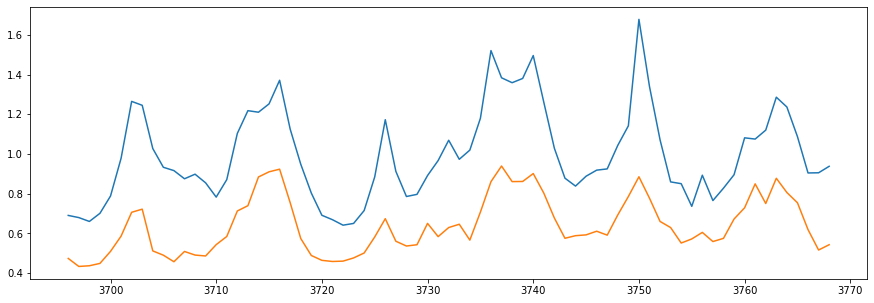

In [136]:
fig,ax=plt.subplots(figsize=[15,5])
startday = 154
ndays=3
start=24*startday
end=start+24*ndays
data1.loc[start:end, 'Building_Electricity'].plot(ax=ax)
data2.loc[start:end, 'Building_Electricity'].plot(ax=ax)

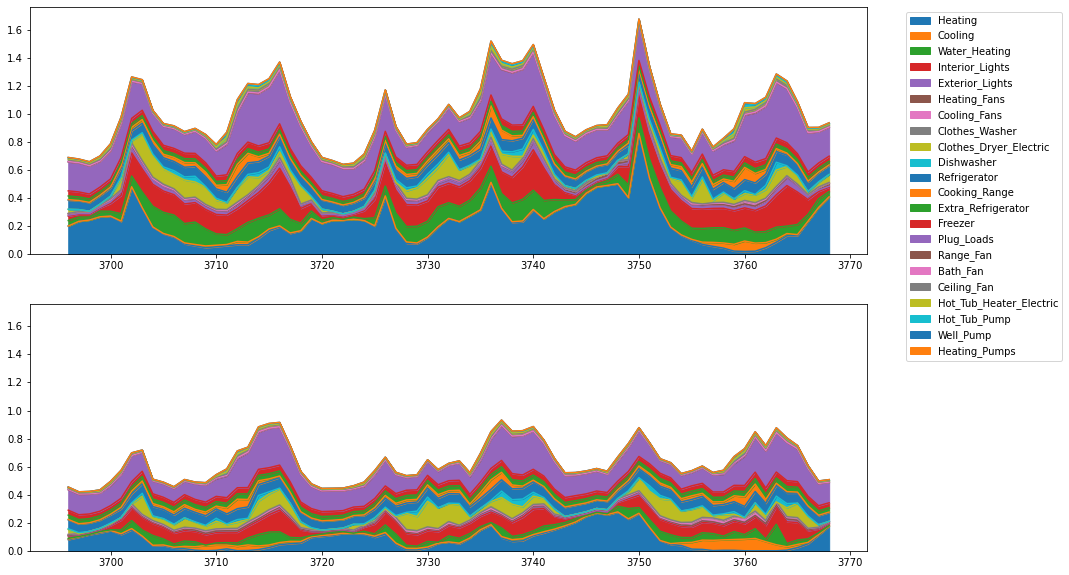

In [137]:
fig,ax=plt.subplots(2,1,figsize=[15,10])
data1.loc[start:end, bldg_eu_cols].plot.area(ax=ax[0], legend=False)
data2.loc[start:end, bldg_eu_cols].plot.area(ax=ax[1], legend=False)
ax[1].set_ylim(ax[0].get_ylim())
ax[0].legend(bbox_to_anchor=[1.04,1.0])

In [138]:
if year==2012:
    loccol = 'location'
else:
    loccol='epw'
'-'.join([data1.loc[0,loccol].split('.')[0], data1.loc[0,'unit_type'].replace(' ','_')])

'CA_Arcata-Mobile_Home'

In [166]:
counter = {}
columns=data1.columns
i=-1
n_at_once = 100 #How many buildings to read in at once
#for j in range(100):

if year==2012:
    print('*****************************************')
    print('Remember to re-run for all files in 2012!')
    print('*****************************************')
    #data_file='Baseline for Upgrade01_8784_hours.csv'
    data_file='Upgrade05_8784_hours.csv'
    loccol='location'
    ic=False
    if 'Baseline' in data_file:
        upgrade = '0'
    else:
        upgrade=data_file.split('_')[0][-1]

else:
    loccol='epw'
    ic=0
    
f = open(os.path.join(indir,
                      r'building_load_shapes', 'file_names.txt'), 'a')
while True:
    i+=1
    data = pd.read_csv(os.path.join(indir, data_file), nrows=8784*n_at_once, 
                       skiprows=range(1,8784*i*n_at_once+1), header=0, 
                       index_col=ic).reset_index(drop=True)
    data = remove_baseline_headers(data)
    #Stop when we run out of data.
    assert len(data)>0, "Oops out of data: "+str(len(data))
    
    for j in range(n_at_once):
        if year!=2012: 
            upgrade = str(dataj.loc[0,'upgrade'])
        dataj = data.iloc[j*8784:(j+1)*8784].reset_index(drop=True)
        assert len(dataj)>0, "Oops, out of data."
        assert len(dataj)==8784, 'Something is wrong with our stride'
        #Make sure we're striding through the years correctly.
        assert dataj.loc[0,'time'] == data1.loc[0,'time']

        #Generate name to check uniqueness by building, weather station, and upgrade
        name='-'.join(['.'.join(dataj.loc[0,loccol].split('.')[:-1]),  
                       'upgrade_'+upgrade,
                       dataj.loc[0,'unit_type'].replace(' ','_'),])
        #Get a counter to append to building type if there is more than one
        if name in counter.keys():
            counter[name]+=1
        else:
            counter[name]=0
        #Re-order for readability
        name='-'.join(['.'.join(dataj.loc[0,loccol].split('.')[:-1]),
                       '_'.join([dataj.loc[0,'unit_type'].replace(' ','_'), 
                                 str(counter[name])]),  
                       'upgrade_'+upgrade])
        #name = '_'.join([name,str(counter[name])])
        print(str(i*n_at_once+j)+': '+name)
        f.write(str(i*n_at_once+j)+': '+name+'\n')
        dataj.to_csv(os.path.join(indir,'building_load_shapes', name+'.csv'))
    #assert False
    
f.close()

*****************************************
Remember to re-run for all files in 2012!
*****************************************
0: CA_Arcata.AP-Mobile_Home_0-upgrade_5
1: CA_Arcata.AP-Multi-Family_with_2_-_4_Units_0-upgrade_5
2: CA_Arcata.AP-Multi-Family_with_5+_Units_0-upgrade_5
3: CA_Arcata.AP-Single-Family_Attached_0-upgrade_5
4: CA_Arcata.AP-Single-Family_Detached_0-upgrade_5
5: CA_Bakersfield-Meadows.Field-Mobile_Home_0-upgrade_5
6: CA_Bakersfield-Meadows.Field-Multi-Family_with_2_-_4_Units_0-upgrade_5
7: CA_Bakersfield-Meadows.Field-Multi-Family_with_5+_Units_0-upgrade_5
8: CA_Bakersfield-Meadows.Field-Single-Family_Attached_0-upgrade_5
9: CA_Bakersfield-Meadows.Field-Single-Family_Detached_0-upgrade_5
10: CA_Barstow.Daggett.AP-Mobile_Home_0-upgrade_5
11: CA_Barstow.Daggett.AP-Multi-Family_with_2_-_4_Units_0-upgrade_5
12: CA_Barstow.Daggett.AP-Multi-Family_with_5+_Units_0-upgrade_5
13: CA_Barstow.Daggett.AP-Single-Family_Attached_0-upgrade_5
14: CA_Barstow.Daggett.AP-Single-Family_

AssertionError: Oops, out of data.

In [155]:
ws = 'TX_Houston-Bush.Intercontinental.AP'

if year == 2012:
    y=''
else:
    y='_2016'
    
upgrade = 1

data3 = pd.read_csv(os.path.join(indir, 'building_load_shapes', 
                                 '{w}{y}-Single-Family_Detached_0-upgrade_0.csv'.format(
                                     w=ws, y=y)))
data4 = pd.read_csv(os.path.join(indir, 'building_load_shapes', 
                                 '{w}{y}-Single-Family_Detached_0-upgrade_{u}.csv'.format(
                                     w=ws, u=upgrade, y=y)))

In [156]:
bldg_eu_cols = eu_cols[data4[eu_cols].sum()>0]
bldg_eu_cols

array(['Heating', 'Cooling', 'Water_Heating', 'Interior_Lights',
       'Exterior_Lights', 'Heating_Fans', 'Cooling_Fans',
       'Clothes_Washer', 'Clothes_Dryer_Electric', 'Dishwasher',
       'Refrigerator', 'Cooking_Range', 'Extra_Refrigerator', 'Freezer',
       'Plug_Loads', 'Range_Fan', 'Bath_Fan', 'Ceiling_Fan',
       'Hot_Tub_Heater_Electric', 'Hot_Tub_Pump', 'Pool_Heater_Electric',
       'Pool_Pump', 'Well_Pump', 'Garage_Lighting', 'Heating_Pumps'],
      dtype='<U28')

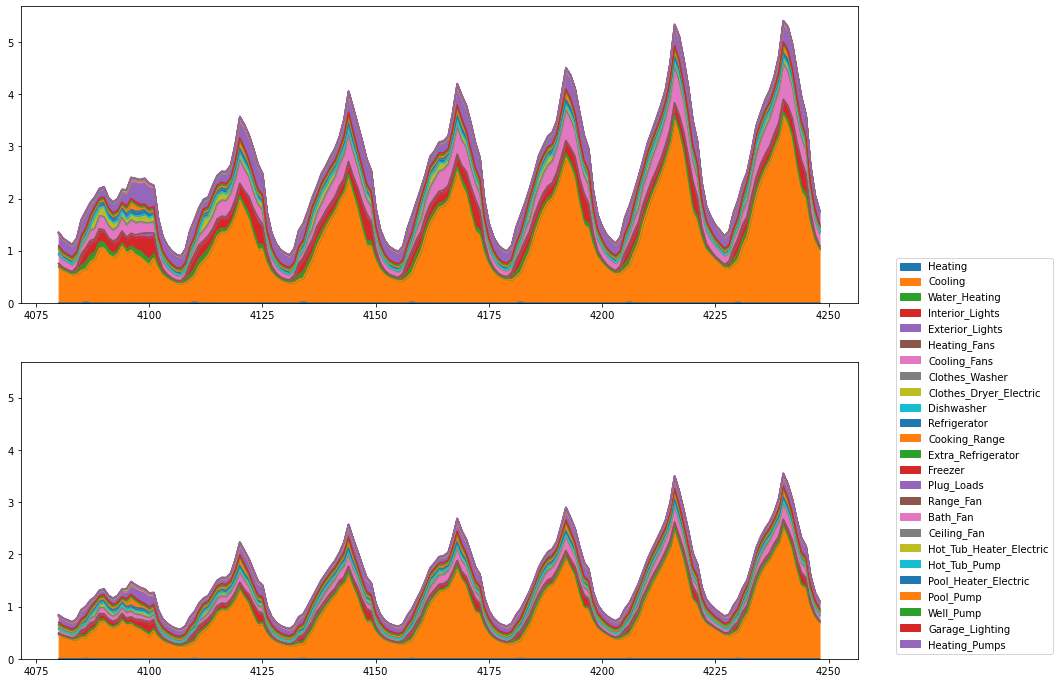

In [157]:
startday = 170
ndays=7
start=24*startday
end=start+24*ndays
fig,ax=plt.subplots(2,1,figsize=[15,12])
data3.loc[start:end, bldg_eu_cols].plot.area(ax=ax[0], legend=False)
data4.loc[start:end, bldg_eu_cols].plot.area(ax=ax[1], legend=False)
ax[1].set_ylim(ax[0].get_ylim())
ax[1].legend(loc='lower left', bbox_to_anchor=[1.04, 0])
#plt.tight_layout()

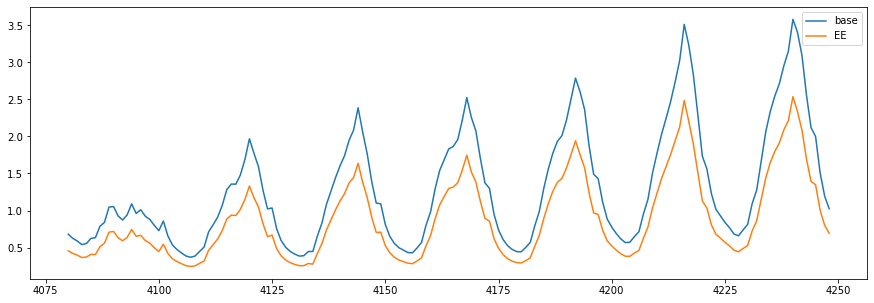

In [158]:
fig,ax=plt.subplots(figsize=[15,5])
eu='Cooling'
data3.loc[start:end, eu].plot(ax=ax, label='base')
data4.loc[start:end, eu].plot(ax=ax, label='EE')
ax.legend()
#ax[1].set_ylim(ax[0].get_ylim())
#fig.legend(loc='lower center', ncol=5, bbox_to_anchor=[0.4, -0.01])

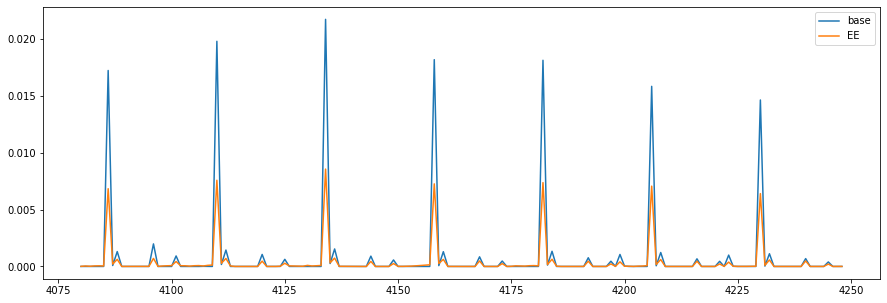

In [159]:
fig,ax=plt.subplots(figsize=[15,5])
eu='Heating'
data3.loc[start:end, eu].plot(ax=ax, label='base')
data4.loc[start:end, eu].plot(ax=ax, label='EE')
ax.legend()

In [160]:
(data3[bldg_eu_cols].sum() - data4[bldg_eu_cols].sum()).round(2)

Heating                     432.77
Cooling                    1979.92
Water_Heating               527.49
Interior_Lights            1084.68
Exterior_Lights             232.10
Heating_Fans                -19.39
Cooling_Fans                785.31
Clothes_Washer                7.39
Clothes_Dryer_Electric      425.18
Dishwasher                   30.86
Refrigerator                204.14
Cooking_Range                 0.00
Extra_Refrigerator            0.00
Freezer                       0.00
Plug_Loads                 1332.49
Range_Fan                     0.00
Bath_Fan                      0.00
Ceiling_Fan                  -0.00
Hot_Tub_Heater_Electric       0.00
Hot_Tub_Pump                  0.00
Pool_Heater_Electric          0.00
Pool_Pump                     7.01
Well_Pump                     0.00
Garage_Lighting              24.47
Heating_Pumps                -0.00
dtype: float64

<AxesSubplot:>

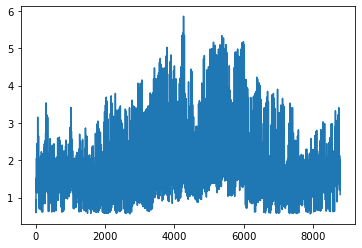

In [161]:
data3['Building_Electricity'].plot()



<AxesSubplot:>

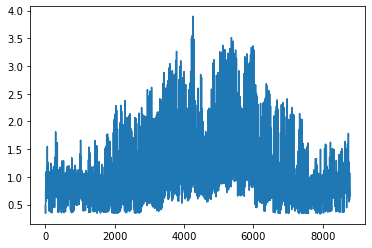

In [162]:
data4['Building_Electricity'].plot()